## **1. Data Preparation**

In [1]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 11.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=6a8423d2a41bddaa831f6ba571d914ddd0cea41b1796c5c8bf98ef448cbcab97
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 9.1MB/s 
     |████████████████████████████████| 2.1MB 29.7MB/s 
     |████████████████████████████████| 9.5MB 16.8MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
# Import necessary libraries and packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings('ignore')

# Import yahoo's finance API library for historical stock data
import yfinance as yf

# Import time-series forecasting libraries
from scipy import stats
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing

In [4]:
# Top 5 NSE Companies by 'Market Cap' as on 24-12-20
top5_tickers = ['RELIANCE.NS','TCS.NS','HDFCBANK.NS','HINDUNILVR.NS','INFY.NS']

In [2]:
def prepare_data(ticker):
    
    # Start date is chosen as per available news data (20-11-2017)
    start_date = datetime.date(2017,11,17)  
    end_date = datetime.date.today()
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')

    # Calculate %change for a day using present and previous day 'Close' prices 
    per_change = 100*(df['Close'].values[1:]-df['Close'].values[:-1])/df['Close'].values[:-1]
    per_change = np.round(per_change, 3)

    # Since, 17-11-2017 has no 'per_change' value, we skip this starting date
    df1 = df[1:].copy()
    df1['%Change'] = per_change
    df1['Trend'] = df1['%Change'].map(lambda x:0 if x<=0 else 1)

    return df1

In [3]:
# Preparing data for top 5 NSE companies
ril_df = prepare_data('RELIANCE.NS')
tcs_df = prepare_data('TCS.NS')
hdfc_df = prepare_data('HDFCBANK.NS')
hul_df = prepare_data('HINDUNILVR.NS')
infy_df = prepare_data('INFY.NS')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
print(ril_df.shape, tcs_df.shape, hdfc_df.shape, hul_df.shape, infy_df.shape)

(769, 8) (769, 8) (769, 8) (769, 8) (769, 8)


## **2. Time Series Models**

### **2.1 Decomposing Time-Series Data**

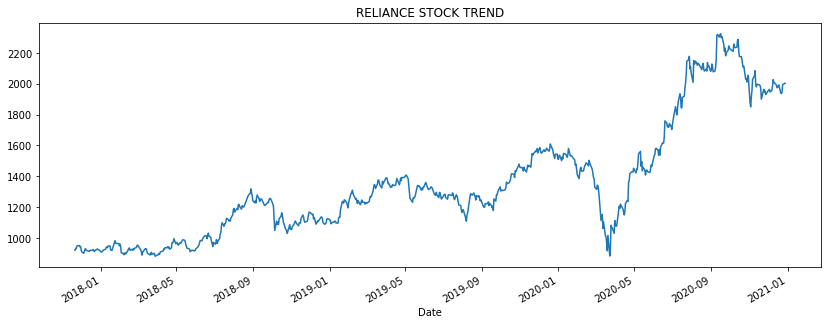

In [ ]:
data = df['Close']
data.plot(figsize=(14,5), title='RELIANCE STOCK TREND')
plt.show()

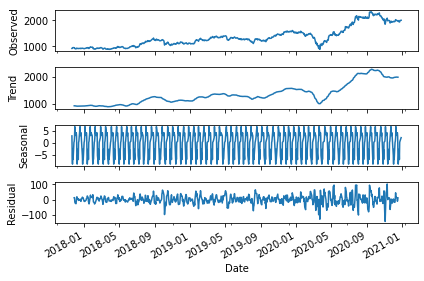

In [ ]:
# Decomposing stock data into time-series components
decomposed_data = seasonal_decompose(data, model='additive', freq=12)
plot_components = decomposed_data.plot()

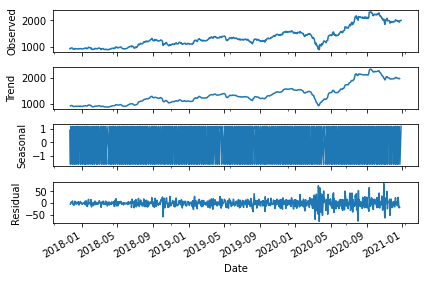

In [ ]:
# Decomposing stock data into time-series components
decomposed_data = seasonal_decompose(data, model='additive', freq=4)
plot_components = decomposed_data.plot()

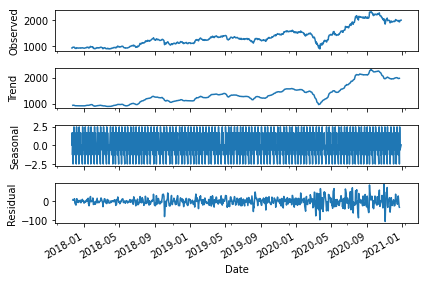

In [ ]:
# Decomposing stock data into time-series components
decomposed_data = seasonal_decompose(data, model='additive', freq=7)
plot_components = decomposed_data.plot()

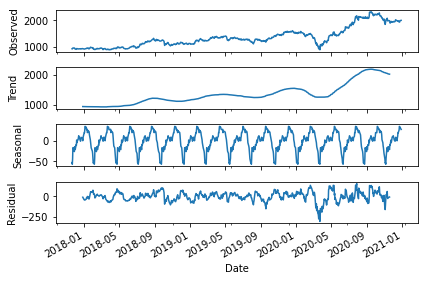

In [ ]:
# Decomposing stock data into time-series components
decomposed_data = seasonal_decompose(data, model='additive', freq=52)
plot_components = decomposed_data.plot()

In [ ]:
train_data = data[:int(0.85*len(data))]
test_data =  data[int(0.85*len(data)):]

print("No. of samples in train data:", train_data.shape)
print("No. of samples in test data:", test_data.shape)

No. of samples in train data: (649,)
No. of samples in test data: (115,)


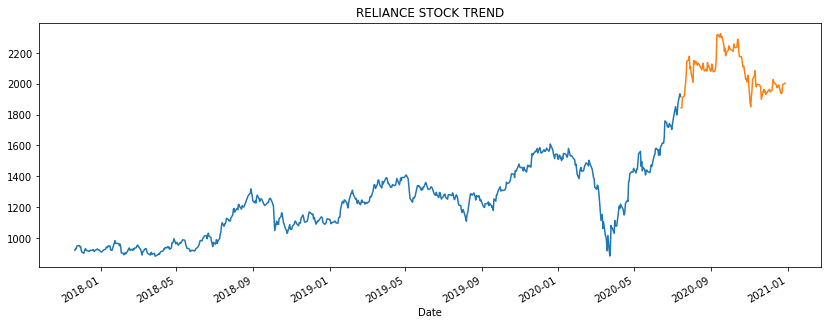

In [ ]:
train_data.plot(figsize=(14,5), title='RELIANCE STOCK TREND')
test_data.plot(figsize=(14,5), title='RELIANCE STOCK TREND')
plt.show()

### **2.2 Moving Average Method**

In [ ]:
# Function for plotting moving averages for actual stock data
def plot_moving_avg(data, windows):
  
    colors = ["r", "g", "m", "k", "y", "c"]
    for window, c in zip(windows, colors):
        ma = data.rolling(window = window).mean().shift(1)
        plt.figure(figsize=(15,5))
        plt.plot(data, label="Actual Close Prices")
        plt.plot(ma, color=c, label="Moving Avg (Window-"+str(window)+")")
        plt.legend(loc="upper left")
        plt.grid(True)
        plt.show()

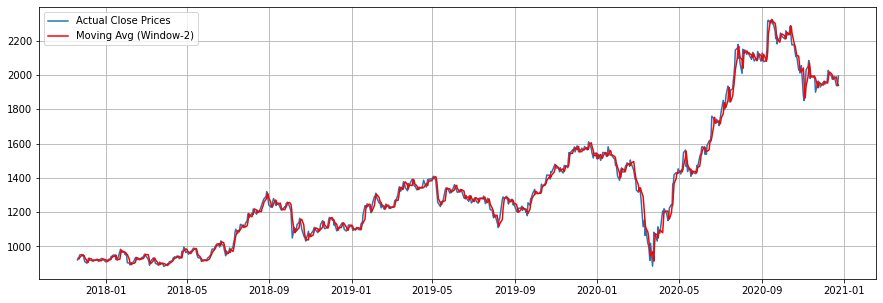

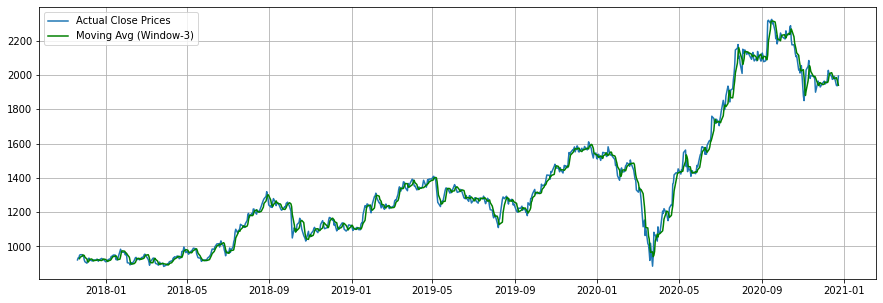

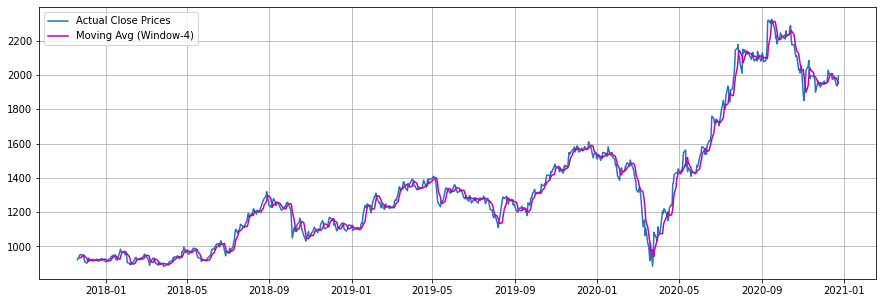

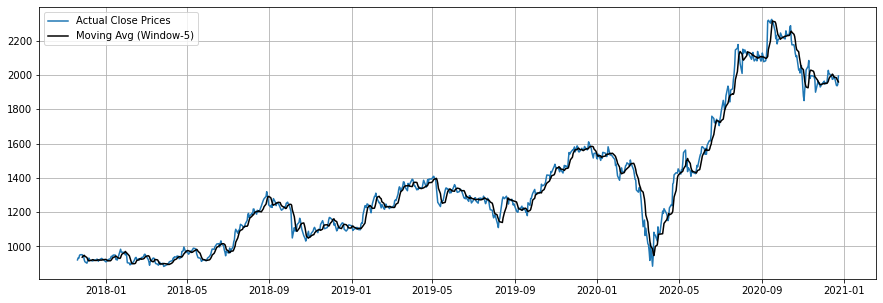

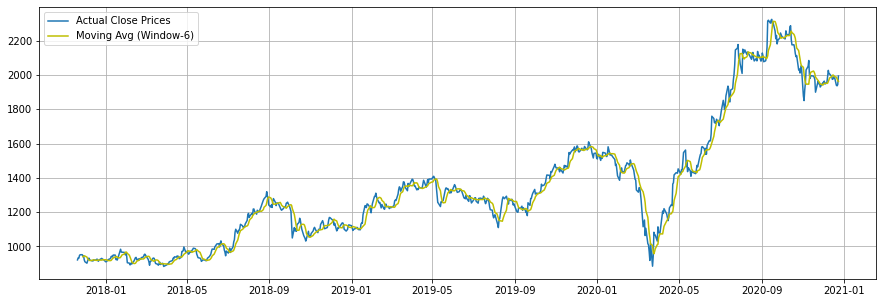

In [ ]:
plot_moving_avg(data, windows=[2,3,4,5,6])

In [ ]:
windows=[2,3,4,5,6]
for window in windows:
    test_predict = data.rolling(window=window).mean().shift(1)[int(0.85*len(data)):]
    rmse = np.sqrt(mean_squared_error(test_data, test_predict))
    print("RMSE for Moving Avg with window size-{}: {}".format(window, rmse))

RMSE for Moving Avg with window size-2: 47.6692451120053
RMSE for Moving Avg with window size-3: 52.817348164311696
RMSE for Moving Avg with window size-4: 57.52209016363907
RMSE for Moving Avg with window size-5: 60.94187865772915
RMSE for Moving Avg with window size-6: 64.47669055280714


### **2.3 Simple Exponential Smoothing**

In [ ]:
# F(t+1) = aY(t) + (1-a)F(t)
alpha_values = [0.1,0.2,0.3,0.4,0.5]
for alpha in alpha_values:
    test_predict = data.ewm(alpha=alpha, adjust=False).mean().shift(1)[int(0.85*len(data)):]
    rmse = np.sqrt(mean_squared_error(test_data, test_predict))
    print("RMSE for SES with alpha-{}: {}".format(alpha, rmse))

RMSE for SES with alpha-0.1: 95.84359653469733
RMSE for SES with alpha-0.2: 66.78836422485392
RMSE for SES with alpha-0.3: 56.83935739236516
RMSE for SES with alpha-0.4: 51.51215703522736
RMSE for SES with alpha-0.5: 48.118234779453715


### **2.4 Double Exponential Smooothing**

In [ ]:
alpha_values = [0.1,0.2,0.4,0.5,0.8]
beta_values = [0.1,0.2,0.4,0.5,0.8]
best_alpha = 0
best_beta = 0
best_rmse = float('inf')
for alpha in alpha_values:
    for beta in beta_values:
        model = Holt(train_data.values).fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
        test_predict = model.forecast(len(test_data))
        rmse = np.sqrt(mean_squared_error(test_data, test_predict))
        print("RMSE for DES with alpha={} & beta={} : {}".format(alpha, beta, rmse))
        if rmse < best_rmse:
            best_rmse = rmse
            best_alpha = alpha
            best_beta = beta

print(60*"-")
print("Best model parameters are alpha={}, beta={} with RMSE={}".format(best_alpha, best_beta, best_rmse))

RMSE for DES with alpha=0.1 & beta=0.1 : 670.2371170675264
RMSE for DES with alpha=0.1 & beta=0.2 : 1013.603745076067
RMSE for DES with alpha=0.1 & beta=0.4 : 520.8591251260888
RMSE for DES with alpha=0.1 & beta=0.5 : 771.9859890090189
RMSE for DES with alpha=0.1 & beta=0.8 : 1358.594071051086
RMSE for DES with alpha=0.2 & beta=0.1 : 779.2882128344548
RMSE for DES with alpha=0.2 & beta=0.2 : 823.780725161918
RMSE for DES with alpha=0.2 & beta=0.4 : 1209.6860634549528
RMSE for DES with alpha=0.2 & beta=0.5 : 1417.7773305129435
RMSE for DES with alpha=0.2 & beta=0.8 : 2249.549253858682
RMSE for DES with alpha=0.4 & beta=0.1 : 884.6630786388822
RMSE for DES with alpha=0.4 & beta=0.2 : 1141.898359320977
RMSE for DES with alpha=0.4 & beta=0.4 : 1627.1901850965387
RMSE for DES with alpha=0.4 & beta=0.5 : 1745.1631388143833
RMSE for DES with alpha=0.4 & beta=0.8 : 1975.3290697770835
RMSE for DES with alpha=0.5 & beta=0.1 : 941.9181295661034
RMSE for DES with alpha=0.5 & beta=0.2 : 1246.447217

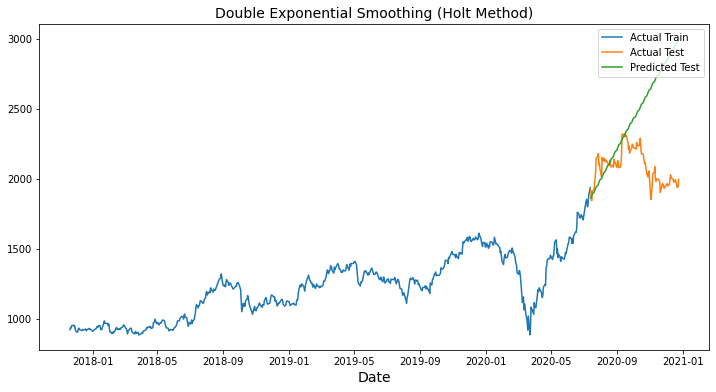

In [ ]:
best_model = Holt(train_data.values).fit(smoothing_level=best_alpha, 
                                         smoothing_slope=best_beta, 
                                         optimized=False)
test_predict = best_model.forecast(len(test_data))
test_predict = pd.Series(test_predict, index=test_data.index)

plt.figure(figsize=(12,6))
plt.plot(train_data, label='Actual Train')
plt.plot(test_data, label='Actual Test')
plt.plot(test_predict, label='Predicted Test')
plt.legend(loc='upper right')
plt.xlabel('Date', fontsize=14)
plt.title('Double Exponential Smoothing (Holt Method)', fontsize=14)
plt.show()

### **2.5 Triple Exponential Smoothing (Holt's Winter Model)**

In [ ]:
alpha_values = [0.1,0.2,0.4,0.5,0.8]
beta_values = [0.1,0.2,0.4,0.5,0.8]
gamma_values = [0.1,0.2,0.4,0.5,0.8]
best_alpha = 0
best_beta = 0
best_gamma = 0
best_rmse = float('inf')
for alpha in alpha_values:
    for beta in beta_values:
        for gamma in gamma_values:
            model = ExponentialSmoothing(train_data.values, seasonal_periods=7, trend='mul', seasonal='add')
            model = model.fit(smoothing_level=alpha, 
                              smoothing_slope=beta, 
                              smoothing_seasonal=gamma,
                              optimized=False)
            test_predict = model.forecast(len(test_data))
            rmse = np.sqrt(mean_squared_error(test_data, test_predict))
            print("RMSE for DES with alpha={}, beta={} & gamma={} : {}".format(alpha, beta, gamma, rmse))
            if rmse < best_rmse:
                best_rmse = rmse
                best_alpha = alpha
                best_beta = beta
                best_gamma = gamma

print(60*"-")
print("Best model parameters are alpha={}, beta={}, gamma={} with RMSE={}". \
      format(best_alpha, best_beta, best_gamma, best_rmse))

RMSE for DES with alpha=0.1, beta=0.1 & gamma=0.1 : 1097.366021209557
RMSE for DES with alpha=0.1, beta=0.1 & gamma=0.2 : 1112.1895974645952
RMSE for DES with alpha=0.1, beta=0.1 & gamma=0.4 : 1110.2184064305204
RMSE for DES with alpha=0.1, beta=0.1 & gamma=0.5 : 1103.667988172893
RMSE for DES with alpha=0.1, beta=0.1 & gamma=0.8 : 1084.7990479063815
RMSE for DES with alpha=0.1, beta=0.2 & gamma=0.1 : 1524.7038993168935
RMSE for DES with alpha=0.1, beta=0.2 & gamma=0.2 : 1384.4757609359017
RMSE for DES with alpha=0.1, beta=0.2 & gamma=0.4 : 1287.4482388949004
RMSE for DES with alpha=0.1, beta=0.2 & gamma=0.5 : 1283.1355554903948
RMSE for DES with alpha=0.1, beta=0.2 & gamma=0.8 : 1346.9764510248917
RMSE for DES with alpha=0.1, beta=0.4 & gamma=0.1 : 1050.1854360903194
RMSE for DES with alpha=0.1, beta=0.4 & gamma=0.2 : 1188.703965045139
RMSE for DES with alpha=0.1, beta=0.4 & gamma=0.4 : 1426.1042435742743
RMSE for DES with alpha=0.1, beta=0.4 & gamma=0.5 : 1525.8155325631885
RMSE for 

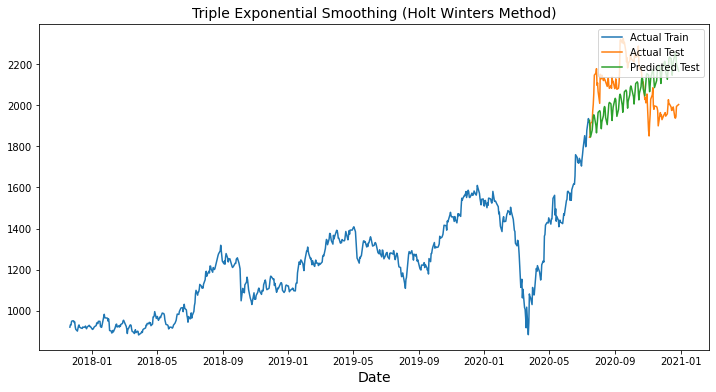

In [ ]:
best_model = ExponentialSmoothing(train_data.values, seasonal_periods=7, trend='add', seasonal='add')
best_model = best_model.fit(smoothing_level=best_alpha, 
                            smoothing_slope=best_beta, 
                            smoothing_seasonal=best_gamma,
                            optimized=False)
test_predict = best_model.forecast(len(test_data))
test_predict = pd.Series(test_predict, index=test_data.index)

plt.figure(figsize=(12,6))
plt.plot(train_data, label='Actual Train')
plt.plot(test_data, label='Actual Test')
plt.plot(test_predict, label='Predicted Test')
plt.legend(loc='upper right')
plt.xlabel('Date', fontsize=14)
plt.title('Triple Exponential Smoothing (Holt Winters Method)', fontsize=14)
plt.show()

### **2.6 ARIMA Model**

In [ ]:
# A check of sationarity of data using Dicky-Fuller test.
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_data)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -0.5650433810838235
p-value: 0.87868679116843


* Since, p-value > 0.05, the data is non-stationary and requires differencing.

In [ ]:
# First order differencing.
diff_1 = train_data.diff().dropna()
result_1 = adfuller(diff_1.dropna())
print('ADF Statistic: {}'.format(result_1[0]))
print('p-value: {}'.format(result_1[1]))

ADF Statistic: -6.813813796090388
p-value: 2.083637074664512e-09


* Now p-value << 0.05, so data is stationary.

In [ ]:
# grid search ARIMA parameters for time series
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.85)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(data.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=803.791
ARIMA(0, 0, 1) RMSE=416.735


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 2) RMSE=296.116
ARIMA(0, 1, 0) RMSE=41.932
ARIMA(0, 1, 1) RMSE=42.042
ARIMA(0, 1, 2) RMSE=42.344
ARIMA(0, 2, 0) RMSE=57.898
ARIMA(0, 2, 1) RMSE=42.234
ARIMA(0, 2, 2) RMSE=42.460
ARIMA(1, 0, 0) RMSE=42.022
ARIMA(1, 0, 1) RMSE=42.121
ARIMA(1, 0, 2) RMSE=42.420
ARIMA(1, 1, 0) RMSE=42.057
ARIMA(1, 1, 1) RMSE=42.320
ARIMA(1, 1, 2) RMSE=42.471
ARIMA(1, 2, 0) RMSE=52.461
ARIMA(1, 2, 1) RMSE=42.482
ARIMA(1, 2, 2) RMSE=42.263
ARIMA(2, 0, 0) RMSE=42.151
ARIMA(2, 0, 1) RMSE=42.057
ARIMA(2, 0, 2) RMSE=42.583
ARIMA(2, 1, 0) RMSE=42.336
ARIMA(2, 1, 1) RMSE=42.556


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

ARIMA(2, 1, 2) RMSE=42.223
ARIMA(2, 2, 0) RMSE=49.764
ARIMA(2, 2, 1) RMSE=42.598


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

ARIMA(2, 2, 2) RMSE=42.413
Best ARIMA(0, 1, 0) RMSE=41.932


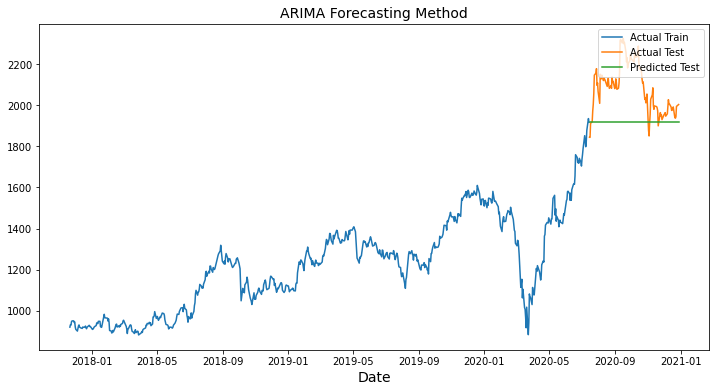

In [ ]:
test_predict = []
for t in range(len(test_data)):
    best_model = ARIMA(train_data.values, order=(0,1,0)).fit()
    yhat = best_model.forecast()[0]
    test_predict.append(yhat)

test_pred = pd.Series(test_predict, index=test_data.index)

plt.figure(figsize=(12,6))
plt.plot(train_data, label='Actual Train')
plt.plot(test_data, label='Actual Test')
plt.plot(test_pred, label='Predicted Test')
plt.legend(loc='upper right')
plt.xlabel('Date', fontsize=14)
plt.title('ARIMA Forecasting Method', fontsize=14)
plt.show()

In [ ]:
test_data

Date
2020-07-15    1844.000000
2020-07-16    1843.400024
2020-07-17    1911.699951
2020-07-20    1919.900024
2020-07-21    1971.550049
                 ...     
2020-12-21    1939.699951
2020-12-22    1936.699951
2020-12-23    1943.849976
2020-12-24    1994.150024
2020-12-28    2003.300049
Name: Close, Length: 115, dtype: float64

In [ ]:
best_model.predict(len(train_data), len(data))

array([1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.,
       1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.,
       1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.,
       1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.,
       1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.,
       1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.,
       1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.,
       1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.,
       1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.,
       1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.,
       1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.,
       1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.,
       1917., 1917., 1917., 1917., 1917., 1917., 1917., 1917.])

### **2.7 Auto ARIMA - RIL**

In [ ]:
# A check of sationarity of data using Dicky-Fuller test.
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_data)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -0.5650433810838235
p-value: 0.87868679116843


* Since, p-value > 0.05, the data is non-stationary and requires differencing.

In [ ]:
# First order differencing.
diff_1 = train_data.diff().dropna()
result_1 = adfuller(diff_1.dropna())
print('ADF Statistic: {}'.format(result_1[0]))
print('p-value: {}'.format(result_1[1]))

ADF Statistic: -6.813813796090388
p-value: 2.083637074664512e-09


* Now p-value << 0.05, so data is stationary.

In [ ]:
from pmdarima import auto_arima

In [ ]:
model_auto_arima = auto_arima(train_data, trace=True, start_p=0, start_q=0, start_P=0, 
                              start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, D=1,
                              max_D=10, seasonal=False, test='adf', stepwise=False)
model_auto_arima.fit(train_data)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6072.779, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6073.733, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6071.955, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6073.690, Time=0.37 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=6075.674, Time=0.46 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=6076.776, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6073.578, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6074.507, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6073.606, Time=0.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6074.975, Time=1.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=6076.239, Time=1.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6072.158, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6073.552, Time=0.48 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6075.381, Time=0.91 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6071.633, Time=1.74 sec
 ARIMA(3,1

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

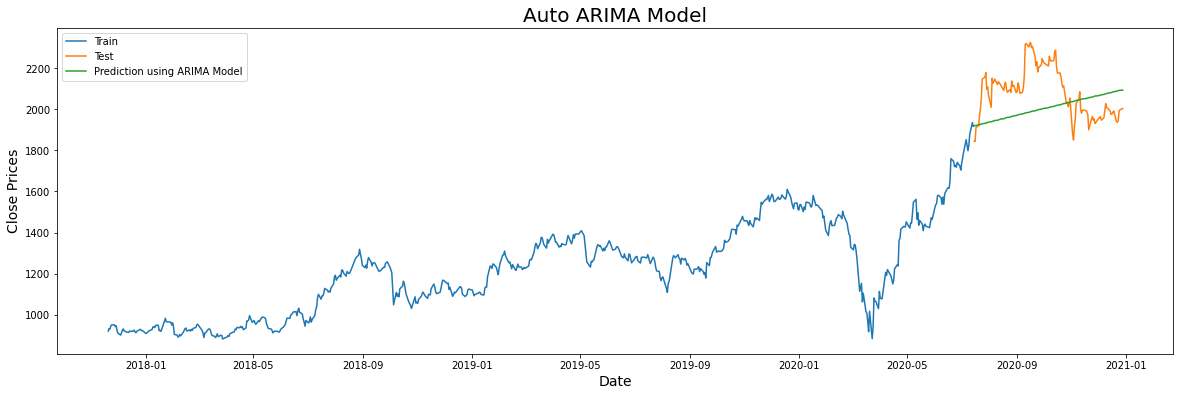

In [ ]:
# Predicting the test values using predict function.
forecast = model_auto_arima.predict(n_periods=len(test_data))
forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Auto ARIMA Model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction using ARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Prices', fontsize=14)
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print("RMSE using ARIMA Model: {}".format(rmse))

RMSE using ARIMA Model: 164.62640872634788


In [ ]:
model_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  649
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -3025.524
Date:                Tue, 29 Dec 2020   AIC                           6065.048
Time:                        12:45:48   BIC                           6096.365
Sample:                             0   HQIC                          6077.197
                                - 649                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.2947      3.679      1.439      0.150      -1.915      12.505
ar.L1         -1.6503      0.064    -25.692      0.000      -1.776      -1.524
ar.L2         -0.8482      0.087     -9.701      0.000      -1.020      -0.677
ar.L3          0.0369      0.039      0.947      0.344      -0.039       0.113
ma.L1          1.6295      0.048     34.127      0.000       1.536       1.723
ma.L2          0.8450      0.047     18.076      0.000       0.753       0.937
sigma2       667.3092     19.916     33.506      0.000     628.274     706.345
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1078.01
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.12   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **2.8(a) Auto ARIMA - HUL Close Prices**

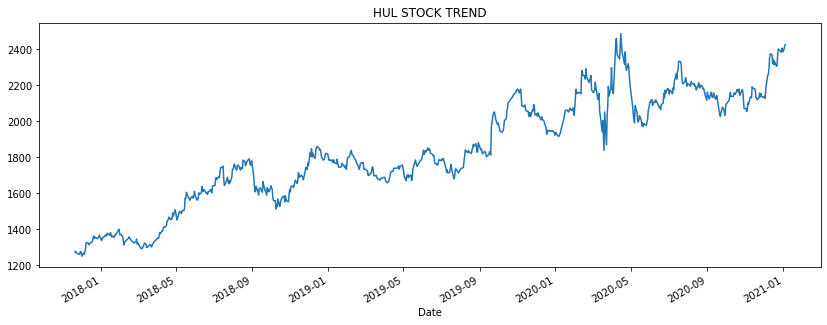

In [17]:
data = hul_df['Close']
data.plot(figsize=(14,5), title='HUL STOCK TREND')
plt.show()

In [18]:
train_data = data[:int(0.90*len(data))]
test_data =  data[int(0.90*len(data)):]

print("No. of samples in train data:", train_data.shape)
print("No. of samples in test data:", test_data.shape)

No. of samples in train data: (692,)
No. of samples in test data: (77,)


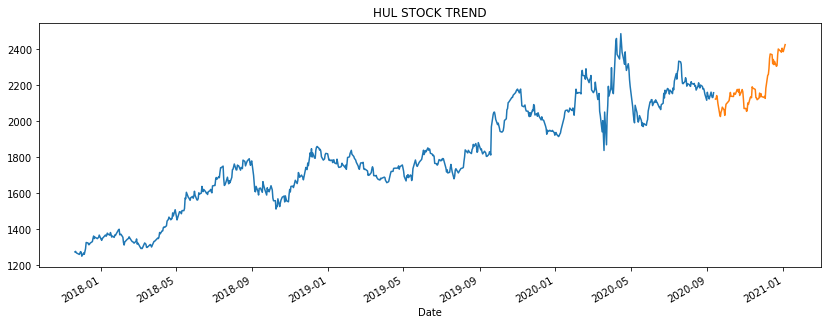

In [19]:
train_data.plot(figsize=(14,5), title='HUL STOCK TREND')
test_data.plot(figsize=(14,5), title='HUL STOCK TREND')
plt.show()

In [8]:
# A check of sationarity of data using Dicky-Fuller test.
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_data)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -1.4529378556382486
p-value: 0.5566507257251596


* Since, p-value > 0.05, the data is non-stationary and requires differencing.

In [9]:
# First order differencing.
diff_1 = train_data.diff().dropna()
result_1 = adfuller(diff_1.dropna())
print('ADF Statistic: {}'.format(result_1[0]))
print('p-value: {}'.format(result_1[1]))

ADF Statistic: -7.841308947667485
p-value: 5.9269164649557885e-12


* Now p-value << 0.05, so data is stationary.

In [10]:
model_auto_arima = auto_arima(train_data, trace=True, start_p=0, start_q=0, start_P=0, 
                              start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, D=1,
                              max_D=10, seasonal=False, test='adf', stepwise=False)
model_auto_arima.fit(train_data)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12335.217, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=10564.156, Time=0.41 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=1.18 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=1.87 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6744.424, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6746.200, Time=0.32 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=6739.900, Time=0.46 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=6738.169, Time=0.58 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.71 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.94 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 4), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

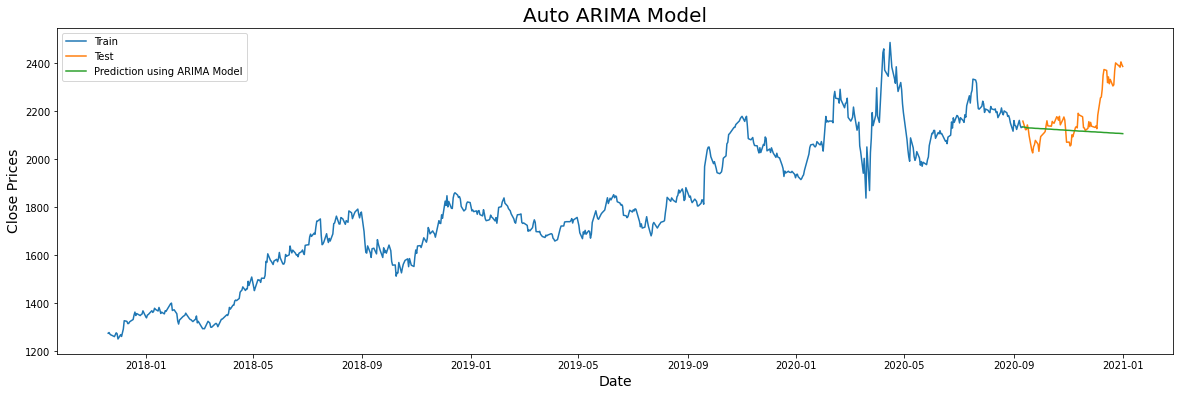

In [11]:
# Predicting the test values using predict function.
forecast = model_auto_arima.predict(n_periods=len(test_data))
forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Auto ARIMA Model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction using ARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Prices', fontsize=14)
plt.show()

In [12]:
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print("RMSE using ARIMA Model: {}".format(rmse))

RMSE using ARIMA Model: 125.34327420456131


### **2.8(b) Auto ARIMA with Seasonality - HUL Close Prices**

In [20]:
model_auto_arima = auto_arima(train_data, trace=True, start_p=0, start_q=0, start_P=0, 
                              start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, D=1,
                              max_D=10, seasonal=True, test='adf', stepwise=False)
model_auto_arima.fit(train_data)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=9786.082, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=8937.471, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=8349.915, Time=0.96 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=6751.844, Time=0.39 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=6753.644, Time=0.71 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=6747.107, Time=1.03 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=6744.983, Time=1.23 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=6753.760, Time=0.82 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=6753.559, Time=0.81 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=6747.018, Time=1.24 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept  

ARIMA(maxiter=50, method='lbfgs', order=(3, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

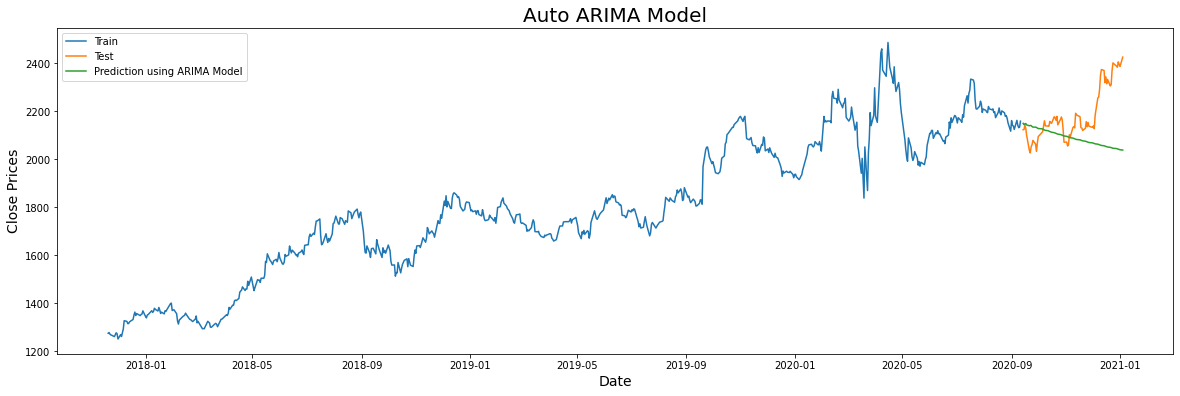

In [21]:
# Predicting the test values using predict function.
forecast = model_auto_arima.predict(n_periods=len(test_data))
forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Auto ARIMA Model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction using ARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Prices', fontsize=14)
plt.show()

In [22]:
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print("RMSE using ARIMA Model: {}".format(rmse))

RMSE using ARIMA Model: 163.22834327386175


### **2.9(a) Auto ARIMA - HUL %Change**

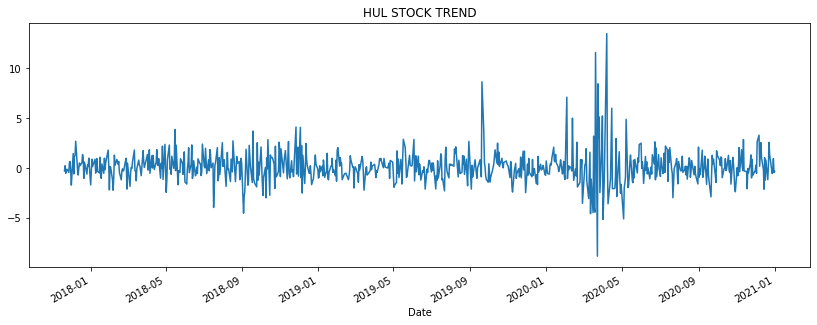

In [14]:
data = hul_df['%Change']
data.plot(figsize=(14,5), title='HUL STOCK TREND')
plt.show()

In [15]:
train_data = data[:int(0.90*len(data))]
test_data =  data[int(0.90*len(data)):]

print("No. of samples in train data:", train_data.shape)
print("No. of samples in test data:", test_data.shape)

No. of samples in train data: (691,)
No. of samples in test data: (77,)


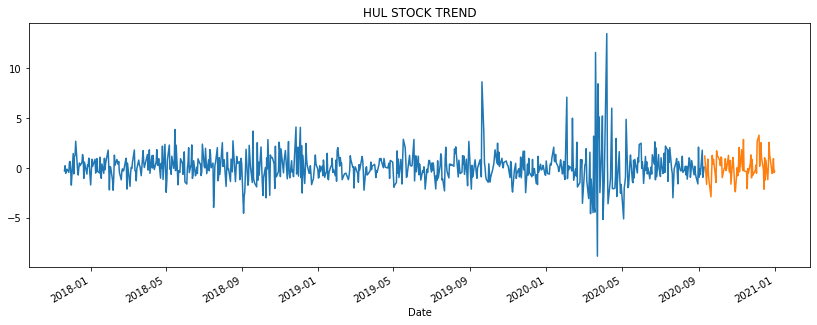

In [16]:
train_data.plot(figsize=(14,5), title='HUL STOCK TREND')
test_data.plot(figsize=(14,5), title='HUL STOCK TREND')
plt.show()

In [17]:
# A check of sationarity of data using Dicky-Fuller test.
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_data)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -9.23996788642246
p-value: 1.5923302001695855e-15


* Since, p-value << 0.05, the data is stationary.

In [18]:
model_auto_arima = auto_arima(train_data, trace=True, start_p=0, start_q=0, start_P=0, 
                              start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, D=1,
                              max_D=10, seasonal=False, test='adf', stepwise=False)
model_auto_arima.fit(train_data)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2650.852, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2640.472, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2642.445, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2639.806, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2639.415, Time=0.10 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2640.890, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2640.783, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2642.459, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2642.093, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2640.792, Time=0.25 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2641.274, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2642.156, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2643.886, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2635.335, Time=0.64 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2637.047, Time=0.40 sec
 ARIMA(3,0

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

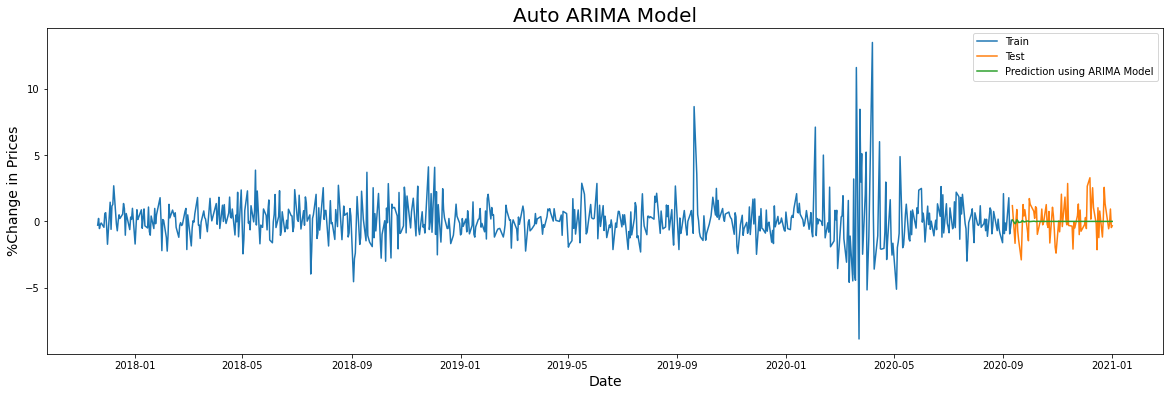

In [20]:
# Predicting the test values using predict function.
forecast = model_auto_arima.predict(n_periods=len(test_data))
forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Auto ARIMA Model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction using ARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('%Change in Prices', fontsize=14)
plt.show()

In [21]:
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print("RMSE using ARIMA Model: {}".format(rmse))

RMSE using ARIMA Model: 1.24171740216856


### **2.9 (b) Auto ARIMA with Seasonality - HUL %Change**

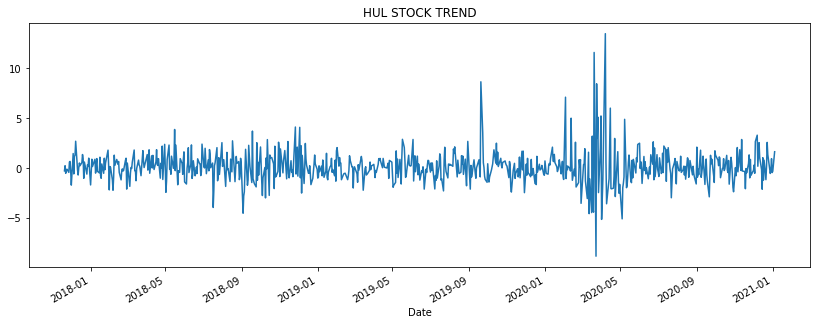

In [5]:
data = hul_df['%Change']
data.plot(figsize=(14,5), title='HUL STOCK TREND')
plt.show()

In [6]:
train_data = data[:int(0.90*len(data))]
test_data =  data[int(0.90*len(data)):]

print("No. of samples in train data:", train_data.shape)
print("No. of samples in test data:", test_data.shape)

No. of samples in train data: (692,)
No. of samples in test data: (77,)


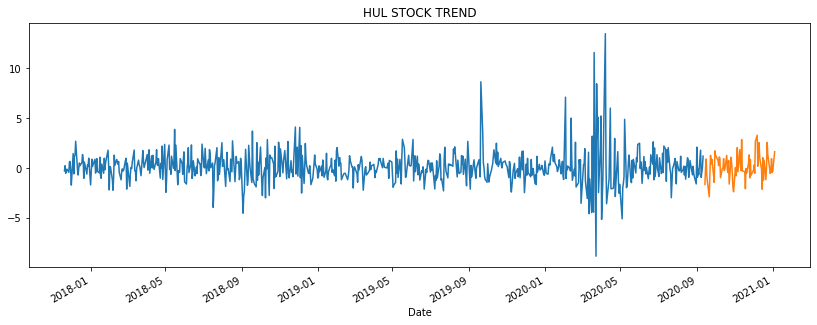

In [7]:
train_data.plot(figsize=(14,5), title='HUL STOCK TREND')
test_data.plot(figsize=(14,5), title='HUL STOCK TREND')
plt.show()

In [8]:
# A check of sationarity of data using Dicky-Fuller test.
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_data)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -9.25693625717973
p-value: 1.441223269668325e-15


* Since, p-value << 0.05, the data is stationary.

In [13]:
model_auto_arima = auto_arima(train_data, trace=True, start_p=0, start_q=0, start_P=0, 
                              start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, D=1,
                              max_D=10, seasonal=True, test='adf', stepwise=False)
model_auto_arima.fit(train_data)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=2654.175, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=2643.057, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=2645.052, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=2642.830, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=2642.583, Time=0.24 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=2643.901, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=2643.490, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=2645.054, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=2645.274, Time=0.36 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=2643.953, Time=0.50 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=2644.411, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=2644.676, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=2646.434, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=2638.031, Time=0.89 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=2639.560, Time=0.78 sec
 ARIMA(3,0

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

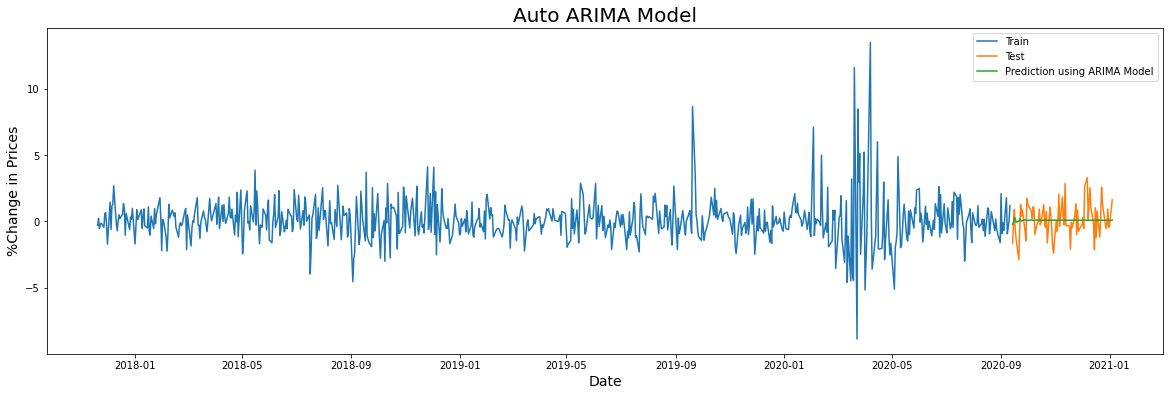

In [14]:
# Predicting the test values using predict function.
forecast = model_auto_arima.predict(n_periods=len(test_data))
forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Auto ARIMA Model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction using ARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('%Change in Prices', fontsize=14)
plt.show()

In [15]:
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print("RMSE using ARIMA Model: {}".format(rmse))

RMSE using ARIMA Model: 1.238389628968694


In [16]:
model_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  692
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1313.016
Date:                Tue, 05 Jan 2021   AIC                           2638.031
Time:                        07:25:35   BIC                           2665.269
Sample:                             0   HQIC                          2648.566
                                - 692                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1490      0.104      1.438      0.150      -0.054       0.352
ar.L1          0.0185      0.105      0.177      0.860      -0.187       0.224
ar.L2         -0.6968      0.076     -9.197      0.000      -0.845      -0.548
ma.L1         -0.1507      0.108     -1.389      0.165      -0.363       0.062
ma.L2          0.6705      0.091      7.342      0.000       0.492       0.849
sigma2         2.6034      0.074     35.032      0.000       2.458       2.749
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              3388.50
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.71   Skew:                             1.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **3. Prophet Library Time Series**

### **3.1 Modelling Prophet** 

In [49]:
from fbprophet import Prophet
import plotly.express as px

import logging
logging.getLogger().setLevel(logging.ERROR)

In [71]:
def prophet_model(train, test):

    model = Prophet(daily_seasonality=True).fit(train)
    future = model.make_future_dataframe(periods=test.shape[0])
    forecast = model.predict(future)
    model.plot(forecast)

    test_pred = forecast[len(train):]['yhat']
    rmse = np.sqrt(mean_squared_error(test['%Change'].values, test_pred.values))
    print('-'*50)
    print("RMSE using Prophet model: {}".format(rmse))
    print('-'*50)

In [73]:
def plot_stock_data(df, ticker, split_ratio=0.85):

    # Addind data column to dataframe
    data = df['%Change']
    data = pd.DataFrame(data)
    data['Date'] = data.index

    # Splitting data
    train_df = data[:int(split_ratio*len(data))]
    test_df = data[int(split_ratio*len(data)):]
    train_df.columns = ['y', 'ds']    # Renaming columns for prophet library

    # Categorizing into train and test data for plotting
    data['Train_or_Test'] = np.nan
    data['Train_or_Test'][0:len(train_df)] = 'Train'
    data['Train_or_Test'][len(train_df):] = 'Test'

    # Line plot using plotly
    fig = px.line(data, x='Date', y='%Change', color='Train_or_Test', 
                  title='Daily %Change in Close Prices for '+ticker)
    fig.show()

    return train_df, test_df

--------------------------------------------------
RMSE using Prophet model: 1.9945461854237345
--------------------------------------------------


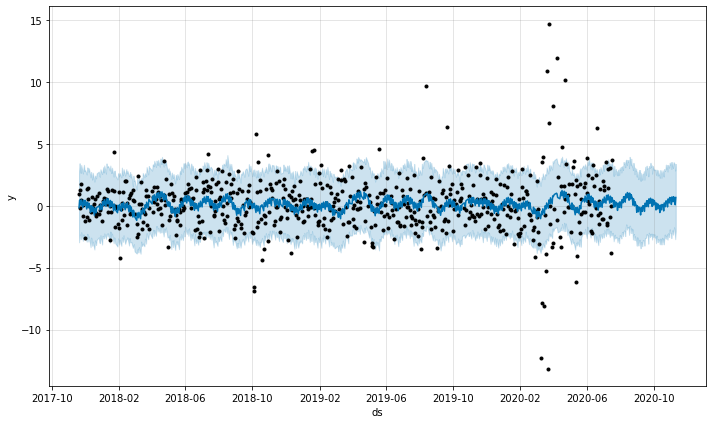

In [74]:
train_df, test_df = plot_stock_data(ril_df, ticker='RELIANCE')
prophet_model(train=train_df, test=test_df)

--------------------------------------------------
RMSE using Prophet model: 1.675448890065648
--------------------------------------------------


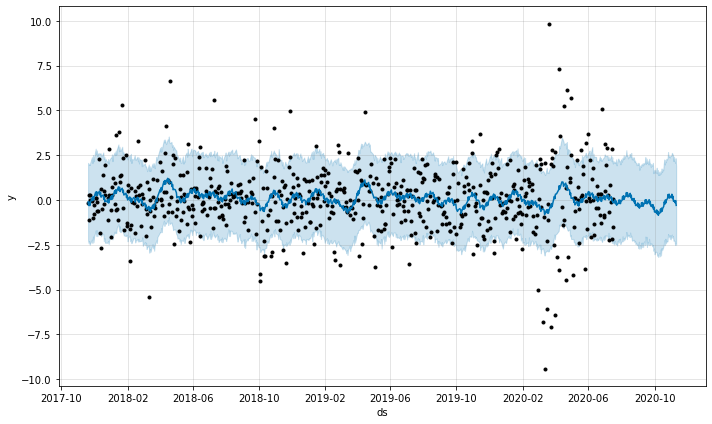

In [75]:
train_df, test_df = plot_stock_data(tcs_df, ticker='TCS')
prophet_model(train=train_df, test=test_df)

--------------------------------------------------
RMSE using Prophet model: 1.7047872580720886
--------------------------------------------------


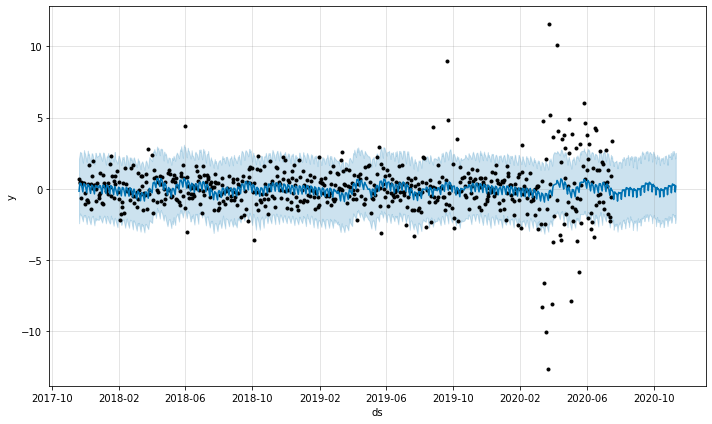

In [76]:
train_df, test_df = plot_stock_data(hdfc_df, ticker='HDFC BANK')
prophet_model(train=train_df, test=test_df)

### **3.2 Box-cox Transformation**

In [82]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [83]:
def prophet_model_boxcox(train, test):

    train = train.copy().set_index('ds')
    train['y'], lambda_prophet = stats.boxcox(train['y'])
    train.reset_index(inplace=True)
    
    model = Prophet(daily_seasonality=True).fit(train)
    future = model.make_future_dataframe(periods=test.shape[0])
    forecast = model.predict(future)
    model.plot(forecast)

    test_pred = inverse_boxcox(forecast[len(train):]['yhat'])
    rmse = np.sqrt(mean_squared_error(test['%Change'].values, test_pred.values))
    print('-'*50)
    print("RMSE using Prophet model: {}".format(rmse))
    print('-'*50)